# MXNet for Collaborative Deep Learning in Recommender Systems
In this tutorial, we build on MXNet to implement the Collaborative Deep Learning (CDL) [1] model for recommender systems.

## Brief Introduction of CDL

In CDL, a probabilistic stacked denoising autoencoder (pSDAE) is connected to a matrix factorization (MF) component. Model training will alternate between pSDAE and MF. In each epoch, a pSDAE with a reconstruction target at the end and a regression target in the bottleneck will be udpated before updating the latent factors U and V in the regularized MF.

Below is the graphical model for CDL. The part in the red rectangle is pSDAE and the rest is the MF component regularized by pSDAE. Essentially, the updating will alternate between pSDAE (updating $W^+$) and the MF component (updating $u$ and $v$).
### Some Notation:
- $x_0$: the input vectors to pSDAE (corrupted data, e.g., randomly deleting some entries of the input)
- $x_c$: the reconstruction target vectors (the uncorrupted data)
- $x_{L/2}$: the output vectors of pSDAE's middle layer (bottleneck layer)
- $X_0$: the matrix consists of vectors $x_0$
- $X_c$: the matrix consists of vectors $x_c$
- $W^+$: weights and biases of pSDAE
- $v$: latent item vectors
- $u$: latent user vectors
- $R$: rating matrix ('1' if the article is in the user's library and '0' otherwise)
- $I$: number of users
- $J$: number of items
- $\lambda_u$, $\lambda_v$, $\lambda_w$, $\lambda_n$: hyperparameters

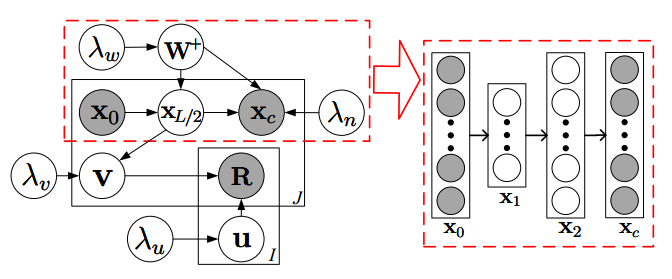

In [23]:
from IPython.display import Image 
Image(filename='PGM-CDL.png')

Below we show a special case of CDL (from a neural network perspective), where it degenerates to simultaneously training two neural networks overlaid together with a common input layer (the corrupted input) but different output layers. This might be a lot easier to understand for people not familiar with graphical models. 

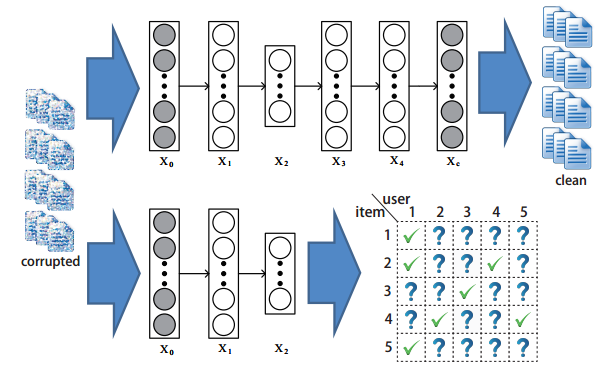

In [24]:
Image(filename='NN-CDL.png')

The objective function (which we use in this implementation) for this special case is:
$$
\begin{align}
\mathscr{L}=&-\frac{\lambda_u}{2}\sum_i ||u_i||_2^2-\frac{\lambda_w}{2}\sum_l(||W_l\|_F^2+\|b_l||_2^2) \nonumber \\
&-\frac{\lambda_v}{2}\sum_j||v_j-f_e(X_{0,j*},W^+)^T||_2^2 \nonumber \\
&-\frac{\lambda_n}{2}\sum_j||f_r(X_{0,j*},W^+)-X_{c,j*}||_2^2 \nonumber \\
&-\sum_{i,j}\frac{C_{ij}}{2}(R_{ij}-u_i^Tv_j)^2,\nonumber \\
\end{align}
$$
where the encoder function $f_e(\cdot,W^+)$ takes the corrupted content vector $X_{0,j*}$ of item $j$ as input and computes the encoding of the item, and the function $f_r(\cdot,W^+)$ also takes $X_{0,j*}$ as input, computes the encoding and then the reconstructed content vector of item $j$. Here $\lambda_w$, $\lambda_n$, $\lambda_u$, and $\lambda_v$ are hyperparameters and $C_{ij}$ is a confidence parameter ($C_{ij} = a$ if $R_{ij}=1$ and $C_{ij}=b$ otherwise). For example, if the number of layers $L=6$, $f_e(X_{0,j*},W^+)$ is the output of the third layer while $f_r(X_{0,j*},W^+)$ is the output of the sixth layer.

To learn CDL, we have to implement the block coordinate descent (BCD) update using numpy/mshadow and call this BCD procedure after each epoch of pSDAE. Besides the MF part, another difference between CDL and conventional deep learning models is that pSDAE has a fixed target at the end and a dynamic target (the latent item factors V) in the bottleneck layer. It might need some hacking to make this work.

[1] H. Wang, N. Wang, and D. Yeung. Collaborative deep learning for recommender systems. In KDD, 2015.

## Implementing CDL in MXNet for Recommender Systerms

In [ ]:
import mxnet as mx
import numpy as np
import logging
import data
from math import sqrt
from autoencoder import AutoEncoderModel
import os

### Setting Hyperparameters
- lambda_u: regularization coefficent for user latent matrix U
- lambda_v: regularization coefficent for item latent matrix V
- K: number of latent factors
- is_dummy: whether to use a dummy dataset for demo
- num_iter: number of iterations (minibatches) to train (a epoch in the used dataset takes about 68 iterations)
- batch_size: minibatch size
- dir_save: directory to save training results
- lv: lambda_v/lambda_n in CDL; this controls the trade-off between reconstruction error in pSDAE and recommendation accuracy during training

In [2]:
lambda_u = 1 # lambda_u in CDL
lambda_v = 10 # lambda_v in CDL
K = 50
p = 1
is_dummy = False
num_iter = 100 # about 68 iterations/epoch, the recommendation results at the end need 100 epochs
batch_size = 256

np.random.seed(1234) # set seed
lv = 1e-2 # lambda_v/lambda_n in CDL
dir_save = 'cdl%d' % p

Create the directory and the log file.

In [3]:
if not os.path.isdir(dir_save):
    os.system('mkdir %s' % dir_save)
fp = open(dir_save+'/cdl.log','w')
print 'p%d: lambda_v/lambda_u/ratio/K: %f/%f/%f/%d' % (p,lambda_v,lambda_u,lv,K)
fp.write('p%d: lambda_v/lambda_u/ratio/K: %f/%f/%f/%d\n' % \
        (p,lambda_v,lambda_u,lv,K))
fp.close()

p1: lambda_v/lambda_u/ratio/K: 10.000000/1.000000/0.010000/50


### Loading Data
Here we load the text information (as input to pSDAE) in the file mult.dat and the rating matrix (as input for the MF part) in the file cf-train-1-users.dat. Code for loading the data are packed in data.py.

We use the CiteULike dataset here. The input text is bag-of-words vectors normalized to [0,1]. Some details:
- task: recommend articles to users
- number of users: 5551
- number of items: 16980
- number of ratings for training: ~169800
- number of terms: 8000

In [4]:
if is_dummy:
    X = data.get_dummy_mult()
    R = data.read_dummy_user()
else:
    X = data.get_mult()
    R = data.read_user()

### Network Definition
Here we deine the logging level and construct the network. As mentioned before, pSDAE has multiple targets, which is why we have to group them as one single symbol (see the commented code below).

In [5]:
logging.basicConfig(level=logging.INFO)
cdl_model = AutoEncoderModel(mx.cpu(2), [X.shape[1],100,K],
    pt_dropout=0.2, internal_act='relu', output_act='relu')
'''
We use the following code to define the pSDAE stucture mentioned before. fe_loss is the regression loss for the bottleneck layer,
and fr_loss is the reconstruction loss in the last layer.

            fe_loss = mx.symbol.LinearRegressionOutput(data=self.lambda_v_rt*self.encoder,
                label=self.lambda_v_rt*self.V)
            fr_loss = mx.symbol.LinearRegressionOutput(data=self.decoder, label=self.data)
            self.loss = mx.symbol.Group([fe_loss, fr_loss])            
'''

### Initializing Variables
Here we initialize several variables. V is the latent item matrix and lambda_v_rt is an ndarray with entries equal to sqrt(lv). We need this lambda_v_rt to hack the trade-off between two targets in pSDAE.

In [6]:
train_X = X
V = np.random.rand(train_X.shape[0],K)/10
lambda_v_rt = np.ones((train_X.shape[0],K))*sqrt(lv)

### Training the CDL
Train the whole CDL (joint training of pSDAE and the connected MF). We use SGD for pSDAE and BCD for the MF part. U is the user latent matrix, V is the item latent matrix, theta is the output of pSDAE's middle layer, and BCD_loss equals to rating_loss+reg_loss_for_U+reg_loss_for_V. For demostration we train for only 100 iterations (about 1.5 epochs) here. The shown recommendations in later parts are results after 100 epochs.

For more details, see the commented code below.

In [7]:
U, V, theta, BCD_loss = cdl_model.finetune(train_X, R, V, lambda_v_rt, lambda_u,
        lambda_v, dir_save, batch_size,
        num_iter, 'sgd', l_rate=0.1, decay=0.0,
        lr_scheduler=mx.misc.FactorScheduler(20000,0.1))
print 'Training ends.'
'''
The function finetune above will call the function 'solve' in the solver.py, where the customized training loop resides. 
In the training loop, we call the following code after each epoch of pSDAE to update U and V using BCD. The BCD updating
procedure is wrapped up in the function BCD_one. Note that after each epoch, we upate U and V for only one iteration.
                theta = model.extract_feature(sym[0], args, auxs,
                    data_iter, X.shape[0], xpu).values()[0]
                # update U, V and get BCD loss
                U, V, BCD_loss = BCD_one(R, U, V, theta,
                    lambda_u, lambda_v, dir_save, True)
                # get recon' loss
                Y = model.extract_feature(sym[1], args, auxs,
                    data_iter, X.shape[0], xpu).values()[0]
                Recon_loss = lambda_v/np.square(lambda_v_rt_old[0,0])*np.sum(np.square(Y-X))/2.0
                lambda_v_rt[:] = lambda_v_rt_old[:] # back to normal lambda_v_rt
                data_iter = mx.io.NDArrayIter({'data': X, 'V': V, 'lambda_v_rt':
                    lambda_v_rt},
                    batch_size=batch_size, shuffle=False,
                    last_batch_handle='pad')
                data_iter.reset()
                batch = data_iter.next()
'''

INFO:root:Fine tuning...
INFO:root:Iter:0 metric:0.001668


Epoch 1 - tr_err/bcd_err/rec_err: 53641376.1/27755.0/53613621.1
Training ends.


### Saving Models and Parameters
Save the network (pSDAE) parameters, latent matrices, and middle-layer output.

In [8]:
cdl_model.save(dir_save+'/cdl_pt.arg')
np.savetxt(dir_save+'/final-U.dat.demo',U,fmt='%.5f',comments='')
np.savetxt(dir_save+'/final-V.dat.demo',V,fmt='%.5f',comments='')
np.savetxt(dir_save+'/final-theta.dat.demo',theta,fmt='%.5f',comments='')

### Computing Training Error
The training loss consists of the loss in pSDAE and that in MF.

In [9]:
Recon_loss = lambda_v/lv*cdl_model.eval(train_X,V,lambda_v_rt)
print "Training error: %.3f" % (BCD_loss+Recon_loss)
fp = open(dir_save+'/cdl.log','a')
fp.write("Training error: %.3f\n" % (BCD_loss+Recon_loss))
fp.close()

Training error: 53629559.864


### Generating Recommendations
Load the latent matrices (U and V), compute the predicted ratings R=UV^T, and generate recommendation lists for each user. There 5551 users in the dataset.

In [10]:
import numpy as np
from data import read_user
def cal_rec(p,cut):
    R_true = read_user('cf-test-1-users.dat')
    dir_save = 'cdl'+str(p)
    U = np.mat(np.loadtxt(dir_save+'/final-U.dat'))
    V = np.mat(np.loadtxt(dir_save+'/final-V.dat'))
    R = U*V.T
    num_u = R.shape[0]
    num_hit = 0
    fp = open(dir_save+'/rec-list.dat','w')
    for i in range(num_u):
        if i!=0 and i%100==0:
            print 'User '+str(i)
        l_score = R[i,:].A1.tolist()
        pl = sorted(enumerate(l_score),key=lambda d:d[1],reverse=True)
        l_rec = list(zip(*pl)[0])[:cut]
        s_rec = set(l_rec)
        s_true = set(np.where(R_true[i,:]>0)[1].A1)
        cnt_hit = len(s_rec.intersection(s_true))
        fp.write('%d:' % cnt_hit)
        fp.write(' '.join(map(str,l_rec)))
        fp.write('\n')
    fp.close()

cal_rec(1,8)

User 100
User 200
User 300
User 400
User 500
User 600
User 700
User 800
User 900
User 1000
User 1100
User 1200
User 1300
User 1400
User 1500
User 1600
User 1700
User 1800
User 1900
User 2000
User 2100
User 2200
User 2300
User 2400
User 2500
User 2600
User 2700
User 2800
User 2900
User 3000
User 3100
User 3200
User 3300
User 3400
User 3500
User 3600
User 3700
User 3800
User 3900
User 4000
User 4100
User 4200
User 4300
User 4400
User 4500
User 4600
User 4700
User 4800
User 4900
User 5000
User 5100
User 5200
User 5300
User 5400
User 5500


### Show Recommendations
Load the article titles (raw-data.csv), ratings (cf-train-1-users.dat and cf-test-1-users.dat), and recommendation lists (rec-list.dat).

In [11]:
import csv
from data import read_user
import numpy as np
p = 1
# read predicted results
dir_save = 'cdl%d' % p
csvReader = csv.reader(open('raw-data.csv','rb'))
d_id_title = dict()
for i,row in enumerate(csvReader):
    if i==0:
        continue
    d_id_title[i-1] = row[3]
R_test = read_user('cf-test-1-users.dat')
R_train = read_user('cf-train-1-users.dat')
fp = open(dir_save+'/rec-list.dat')
lines = fp.readlines()

Show the titles of articles in the training set and titles of recommended articles. Correctly recommended articles are marked by asterisks.

In [13]:
user_id = 3
s_test = set(np.where(R_test[user_id,:]>0)[1].A1)
l_train = np.where(R_train[user_id,:]>0)[1].A1.tolist()
l_pred = map(int,lines[user_id].strip().split(':')[1].split(' '))
print '##########  User '+str(user_id)+'  ##########\n'
print '#####  Articles in the Training Sets  #####'
for i in l_train:
    print d_id_title[i]
print '\n#####  Articles Recommended (Correct Ones Marked by Asterisks)  #####'
for i in l_pred:
    if i in s_test:
        print '* '+d_id_title[i]
    else:
        print d_id_title[i]
fp.close()

##########  User 3  ##########

#####  Articles in the Training Sets  #####
Formal Ontology and Information Systems
Ontologies: a silver bullet for knowledge management and electronic commerce
Business Process Execution Language for Web Services version 1.1
Unraveling the Web services web: an introduction to SOAP, WSDL, and UDDI
A cookbook for using the model-view controller user interface paradigm in Smalltalk-80
Object-oriented application frameworks
Data integration: a theoretical perspective
Web services: been there, done that?
Sweetening Ontologies with DOLCE
Naive Geography

#####  Articles Recommended (Correct Ones Marked by Asterisks)  #####
* The Semantic Web
* A Translation Approach to Portable Ontology Specifications
The Semantic Web Revisited
Towards principles for the design of ontologies used for knowledge sharing
Semantic integration: a survey of ontology-based approaches
OWL Web Ontology Language Overview
Toward Principles for the Design of Ontologies Used for Knowledge